In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from surrogate_model_training_data import get_data

# Get network informations

In [30]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

# Data Pre-Processing

Get clusters:

In [38]:
cluster_label_path = '../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_only_mpc_03.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_only_mpc_03.json')
n_clusters = 30

# Create Training Data:

## with random control input:

In [ ]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
n_arx = 0
nn_input_rc, nn_output_rc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=True)
nn_input_rc.shape

Apply filters:

In [31]:
def filter_io(nn_input, nn_output):
    # All filters are formulated, such that they select data to be removed.
    
    f_1 = (nn_output[('aux_outputs','pump_energy')]<=-100).any(axis=1)
    f_2 = (nn_output[('aux_outputs','jun_cl_press_mean')]<=-10).any(axis=1)

    # Maximum junction pressure should not exceed .. :
    jun_cl_press_fac_max = pressure_factor.groupby(cluster_labels.loc['pressure_cluster'], axis=1).max()
    f_3 = ((nn_output[('aux_outputs','jun_cl_press_mean')]*jun_cl_press_fac_max.to_numpy())>=400).any(axis=1)

    # Tank level should not become smaller than 0.2 at next timestep:
    #f_4 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])<=0.01).any(axis=1)
    
    # Tank level should not be at the maximum
    #max_tank_level = np.array([6.75, 6.5, 5, 5.5, 4.5, 5.9, 4.7]).reshape(1,-1)
    #f_5 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])>max_tank_level-0.01).any(axis=1)
    
    min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56]).reshape(1,-1)
    f_5 = (nn_input[('sys_inputs','head_pump_speed')]<min_pump_setting).any(axis=1)
    
    f = ~f_1&~f_2&~f_3&~f_5
    return f

In [ ]:
f = filter_io(nn_input_rc, nn_output_rc)
nn_input_rc_filtered = nn_input_rc.loc[f]
nn_output_rc_filtered = nn_output_rc.loc[f]
nn_input_rc_filtered.shape

## without random control input:

In [ ]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_nc, nn_output_nc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=True)
nn_input_nc.shape

In [ ]:
# Manually setting the pump setting to the lowest value that results in a shutoff.
min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56])
for i,pump_i in enumerate(link_names[0]):
    f1 = (nn_input_nc[('sys_inputs','head_pump_speed',pump_i)]<min_pump_setting[i])
    nn_input_nc[('sys_inputs','head_pump_speed',pump_i)].loc[f1] = min_pump_setting[i]  

In [ ]:
f = filter_io(nn_input_nc, nn_output_nc)
nn_input_nc_filtered = nn_input_nc.loc[f]
nn_output_nc_filtered = nn_output_nc.loc[f]
nn_input_nc_filtered.shape

In [ ]:
n_data_nc = 2000
nn_input_nc_sampled = nn_input_nc_filtered.head(n_data_nc)
nn_output_nc_sampled = nn_output_nc_filtered.head(n_data_nc)
nn_input_nc_sampled.shape

## From previous MPC solutions

In [55]:
data_path_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/001_economic/',
            '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/']

file_list = []
for data_path in data_path_list:
    in_dir = os.listdir(data_path)
    file_list.extend([data_path+file_i for file_i in in_dir if '.pkl' in file_i])

n_arx = 0
nn_input_mpc, nn_output_mpc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=False, shift_aux_out=True)
nn_input_mpc.shape

(11200, 46)

In [56]:
f = filter_io(nn_input_mpc, nn_output_mpc)
nn_input_mpc_filtered = nn_input_mpc.loc[f]
nn_output_mpc_filtered = nn_output_mpc.loc[f]

nn_input_mpc_filtered.shape

(5411, 46)

In [57]:
n_aug_mpc = 1
nn_input_mpc_augmented = pd.concat(n_aug_mpc*[nn_input_mpc_filtered])
nn_output_mpc_augmented = pd.concat(n_aug_mpc*[nn_output_mpc_filtered])
nn_input_mpc_augmented.shape

(5411, 46)

## Concatenate everything:

In [58]:
 #nn_input =  pd.concat((#nn_input_rc_filtered,  
 #                       nn_input_nc_sampled,  
 #                       nn_input_mpc_augmented), axis=0)
 #nn_output = pd.concat((#nn_output_rc_filtered, 
 #                       nn_output_nc_sampled, 
 #                       nn_output_mpc_augmented), axis=0)

nn_input =  nn_input_mpc_filtered
nn_output = nn_output_mpc_filtered

## Manually extend data to balance histogramms on input space

In [ ]:
cond = nn_input[('sys_states','tank_press','T6')]<4.9
nn_input = pd.concat((nn_input, nn_input.loc[cond]))
nn_output = pd.concat((nn_output, nn_output.loc[cond]))

In [ ]:
nn_input.shape

In [ ]:
nn_input[('sys_states','tank_press')].hist()
#nn_input[('sys_inputs','head_pump_speed')].hist()
#nn_input[('sys_inputs','PRValve_dp')].hist()
#nn_input[('sys_inputs','TCValve_throttle')].hist()
#nn_input[('sys_inputs','jun_cl_demand_sum')].hist()


### Normalize Data:

In [59]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.max()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

In [60]:
output_scaling

sys_states   tank_press         T3        1.774013
                                T1        0.767135
                                T7        2.934528
                                T6        1.510512
                                T5        1.754637
                                T2        1.238836
                                T4        2.719155
aux_outputs  pump_energy        PU2     395.495848
                                PU5     217.083594
                                PU6     355.170424
                                PU8     147.829062
                                PU10    128.847500
             jun_cl_press_mean  0         5.504382
                                1         1.193571
                                2         4.475204
                                3         4.018239
                                4         9.036510
                                5         4.155314
                                6         2.338594
                               

### Train / Test Splitting

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [62]:
X_train.shape

(4328, 46)

# Neural Network

## Create Model

In [63]:
n_layer = 5
n_units = 50
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2350      
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 42)                2142      
Total params: 12,142
Trainable params: 12,142
Non-trainable params: 0
_______________________________________________________

## Train model

In [64]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [65]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=500, 
                    epochs=5000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),)
                    #callbacks=[callback])

Train on 4328 samples, validate on 1083 samples
Epoch 1/5000
4328/4328 [==============================] - 1s 267us/sample - loss: 0.1008 - val_loss: 0.0500
Epoch 2/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 0.0381 - val_loss: 0.0268
Epoch 3/5000
4328/4328 [==============================] - 0s 42us/sample - loss: 0.0242 - val_loss: 0.0239
Epoch 4/5000
4328/4328 [==============================] - 0s 48us/sample - loss: 0.0227 - val_loss: 0.0213
Epoch 5/5000
4328/4328 [==============================] - 0s 41us/sample - loss: 0.0200 - val_loss: 0.0192
Epoch 6/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 0.0184 - val_loss: 0.0179
Epoch 7/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 0.0171 - val_loss: 0.0166
Epoch 8/5000
4328/4328 [==============================] - 0s 45us/sample - loss: 0.0159 - val_loss: 0.0154
Epoch 9/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 0.0149 - val_l

4328/4328 [==============================] - 0s 57us/sample - loss: 0.0034 - val_loss: 0.0035
Epoch 77/5000
4328/4328 [==============================] - 0s 40us/sample - loss: 0.0034 - val_loss: 0.0035
Epoch 78/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 0.0033 - val_loss: 0.0035
Epoch 79/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 0.0033 - val_loss: 0.0034
Epoch 80/5000
4328/4328 [==============================] - 0s 32us/sample - loss: 0.0033 - val_loss: 0.0034
Epoch 81/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 0.0033 - val_loss: 0.0034
Epoch 82/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 0.0032 - val_loss: 0.0033
Epoch 83/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 0.0032 - val_loss: 0.0033
Epoch 84/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 0.0031 - val_loss: 0.0033
Epoch 85/5000
4328/4328 [=================

4328/4328 [==============================] - 0s 35us/sample - loss: 0.0022 - val_loss: 0.0023
Epoch 152/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 0.0022 - val_loss: 0.0023
Epoch 153/5000
4328/4328 [==============================] - 0s 25us/sample - loss: 0.0022 - val_loss: 0.0023
Epoch 154/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 0.0022 - val_loss: 0.0023
Epoch 155/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 0.0022 - val_loss: 0.0022
Epoch 156/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 0.0021 - val_loss: 0.0023
Epoch 157/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 0.0021 - val_loss: 0.0022
Epoch 158/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 0.0021 - val_loss: 0.0023
Epoch 159/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 0.0021 - val_loss: 0.0022
Epoch 160/5000
4328/4328 [========

4328/4328 [==============================] - 0s 19us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 227/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 228/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 229/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 230/5000
4328/4328 [==============================] - 0s 19us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 231/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 232/5000
4328/4328 [==============================] - 0s 19us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 233/5000
4328/4328 [==============================] - 0s 19us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 234/5000
4328/4328 [==============================] - 0s 19us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 235/5000
4328/4328 [========

4328/4328 [==============================] - 0s 22us/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 302/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 303/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 304/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 305/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 306/5000
4328/4328 [==============================] - 0s 19us/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 307/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 0.0014 - val_loss: 0.0017
Epoch 308/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 309/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 310/5000
4328/4328 [========

4328/4328 [==============================] - 0s 20us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 377/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 378/5000
4328/4328 [==============================] - 0s 32us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 379/5000
4328/4328 [==============================] - 0s 26us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 380/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 381/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 382/5000
4328/4328 [==============================] - 0s 32us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 383/5000
4328/4328 [==============================] - 0s 48us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 384/5000
4328/4328 [==============================] - 0s 25us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 385/5000
4328/4328 [========

4328/4328 [==============================] - 0s 20us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 452/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 453/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 454/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 455/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 456/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 457/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 458/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 459/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 460/5000
4328/4328 [========

4328/4328 [==============================] - 0s 37us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 527/5000
4328/4328 [==============================] - 0s 32us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 528/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 529/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 530/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 531/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 9.9270e-04 - val_loss: 0.0012
Epoch 532/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 533/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 534/5000
4328/4328 [==============================] - 0s 32us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 535/5000
4328/4328 [====

4328/4328 [==============================] - 0s 24us/sample - loss: 9.4712e-04 - val_loss: 0.0011
Epoch 600/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 9.3997e-04 - val_loss: 0.0011
Epoch 601/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 9.4847e-04 - val_loss: 0.0011
Epoch 602/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 9.3281e-04 - val_loss: 0.0011
Epoch 603/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 9.1467e-04 - val_loss: 0.0011
Epoch 604/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 9.2426e-04 - val_loss: 0.0011
Epoch 605/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 9.1329e-04 - val_loss: 0.0011
Epoch 606/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 9.0942e-04 - val_loss: 0.0011
Epoch 607/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 9.0307e-04 - val_loss: 0.001

4328/4328 [==============================] - 0s 41us/sample - loss: 8.4618e-04 - val_loss: 0.0010
Epoch 672/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 8.5450e-04 - val_loss: 0.0010
Epoch 673/5000
4328/4328 [==============================] - 0s 31us/sample - loss: 8.4117e-04 - val_loss: 0.0011
Epoch 674/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 8.9512e-04 - val_loss: 0.0011
Epoch 675/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 8.5437e-04 - val_loss: 0.0011
Epoch 676/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 8.6333e-04 - val_loss: 0.0011
Epoch 677/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 8.8536e-04 - val_loss: 0.0011
Epoch 678/5000
4328/4328 [==============================] - 0s 25us/sample - loss: 8.7720e-04 - val_loss: 0.0011
Epoch 679/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 8.7338e-04 - val_loss: 0.001

4328/4328 [==============================] - 0s 40us/sample - loss: 7.9901e-04 - val_loss: 9.8911e-04
Epoch 743/5000
4328/4328 [==============================] - 0s 31us/sample - loss: 8.1809e-04 - val_loss: 0.0010
Epoch 744/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 8.2175e-04 - val_loss: 0.0010
Epoch 745/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 8.4413e-04 - val_loss: 0.0010
Epoch 746/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 8.2668e-04 - val_loss: 9.8855e-04
Epoch 747/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 7.9422e-04 - val_loss: 9.9624e-04
Epoch 748/5000
4328/4328 [==============================] - 0s 25us/sample - loss: 7.8372e-04 - val_loss: 9.6838e-04
Epoch 749/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 7.9460e-04 - val_loss: 0.0011
Epoch 750/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 8.1441e-04 -

Epoch 813/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 7.6432e-04 - val_loss: 0.0010
Epoch 814/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 7.5629e-04 - val_loss: 9.3333e-04
Epoch 815/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 7.5166e-04 - val_loss: 9.1208e-04
Epoch 816/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 7.6146e-04 - val_loss: 9.7709e-04
Epoch 817/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 7.4241e-04 - val_loss: 9.2901e-04
Epoch 818/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 7.5296e-04 - val_loss: 9.6752e-04
Epoch 819/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 7.8365e-04 - val_loss: 0.0010
Epoch 820/5000
4328/4328 [==============================] - 0s 40us/sample - loss: 7.9782e-04 - val_loss: 9.5706e-04
Epoch 821/5000
4328/4328 [==============================] - 0s 33us/samp

4328/4328 [==============================] - 0s 25us/sample - loss: 7.8134e-04 - val_loss: 9.0548e-04
Epoch 884/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 7.2555e-04 - val_loss: 9.6206e-04
Epoch 885/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 7.2125e-04 - val_loss: 8.8567e-04
Epoch 886/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 7.1830e-04 - val_loss: 8.8610e-04
Epoch 887/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 7.2132e-04 - val_loss: 9.2545e-04
Epoch 888/5000
4328/4328 [==============================] - 0s 43us/sample - loss: 7.3123e-04 - val_loss: 0.0010
Epoch 889/5000
4328/4328 [==============================] - 0s 44us/sample - loss: 9.0521e-04 - val_loss: 9.8283e-04
Epoch 890/5000
4328/4328 [==============================] - 0s 46us/sample - loss: 8.3463e-04 - val_loss: 9.4834e-04
Epoch 891/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 

4328/4328 [==============================] - 0s 40us/sample - loss: 6.7836e-04 - val_loss: 8.6840e-04
Epoch 954/5000
4328/4328 [==============================] - 0s 32us/sample - loss: 7.0351e-04 - val_loss: 9.9255e-04
Epoch 955/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 7.9020e-04 - val_loss: 9.2292e-04
Epoch 956/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 7.2758e-04 - val_loss: 9.1439e-04
Epoch 957/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 7.0746e-04 - val_loss: 9.3027e-04
Epoch 958/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 6.9419e-04 - val_loss: 8.8143e-04
Epoch 959/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 6.7483e-04 - val_loss: 9.2512e-04
Epoch 960/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 7.2216e-04 - val_loss: 9.1341e-04
Epoch 961/5000
4328/4328 [==============================] - 0s 20us/sample - lo

4328/4328 [==============================] - 0s 23us/sample - loss: 6.4183e-04 - val_loss: 8.4354e-04
Epoch 1024/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 6.5636e-04 - val_loss: 8.5732e-04
Epoch 1025/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 6.5173e-04 - val_loss: 8.5951e-04
Epoch 1026/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 6.6545e-04 - val_loss: 8.5425e-04
Epoch 1027/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 6.5262e-04 - val_loss: 8.6736e-04
Epoch 1028/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 6.7789e-04 - val_loss: 8.6408e-04
Epoch 1029/5000
4328/4328 [==============================] - 0s 50us/sample - loss: 6.8972e-04 - val_loss: 8.6782e-04
Epoch 1030/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 7.1505e-04 - val_loss: 8.7759e-04
Epoch 1031/5000
4328/4328 [==============================] - 0s 24us/sam

4328/4328 [==============================] - 0s 52us/sample - loss: 6.4027e-04 - val_loss: 8.4185e-04
Epoch 1093/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 6.2607e-04 - val_loss: 8.2336e-04
Epoch 1094/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 6.2414e-04 - val_loss: 8.3893e-04
Epoch 1095/5000
4328/4328 [==============================] - 0s 31us/sample - loss: 6.2207e-04 - val_loss: 8.3412e-04
Epoch 1096/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 6.4696e-04 - val_loss: 8.1562e-04
Epoch 1097/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 6.4724e-04 - val_loss: 8.2360e-04
Epoch 1098/5000
4328/4328 [==============================] - 0s 44us/sample - loss: 6.3912e-04 - val_loss: 8.3757e-04
Epoch 1099/5000
4328/4328 [==============================] - 0s 42us/sample - loss: 6.3285e-04 - val_loss: 8.7807e-04
Epoch 1100/5000
4328/4328 [==============================] - 0s 33us/sam

4328/4328 [==============================] - 0s 33us/sample - loss: 6.2718e-04 - val_loss: 8.2079e-04
Epoch 1162/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 6.1621e-04 - val_loss: 8.1881e-04
Epoch 1163/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 6.1387e-04 - val_loss: 8.0011e-04
Epoch 1164/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 6.2561e-04 - val_loss: 8.0041e-04
Epoch 1165/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 6.1641e-04 - val_loss: 8.5298e-04
Epoch 1166/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 6.3789e-04 - val_loss: 8.5509e-04
Epoch 1167/5000
4328/4328 [==============================] - 0s 43us/sample - loss: 6.2287e-04 - val_loss: 8.0659e-04
Epoch 1168/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 6.2445e-04 - val_loss: 8.0312e-04
Epoch 1169/5000
4328/4328 [==============================] - 0s 34us/sam

4328/4328 [==============================] - 0s 34us/sample - loss: 5.9578e-04 - val_loss: 7.9069e-04
Epoch 1231/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 5.9619e-04 - val_loss: 8.1406e-04
Epoch 1232/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 5.8919e-04 - val_loss: 7.7905e-04
Epoch 1233/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 5.7975e-04 - val_loss: 7.8532e-04
Epoch 1234/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 6.1129e-04 - val_loss: 8.7864e-04
Epoch 1235/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 7.2310e-04 - val_loss: 8.1932e-04
Epoch 1236/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 6.1278e-04 - val_loss: 8.4252e-04
Epoch 1237/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 6.2728e-04 - val_loss: 8.2825e-04
Epoch 1238/5000
4328/4328 [==============================] - 0s 29us/sam

4328/4328 [==============================] - 0s 49us/sample - loss: 5.7339e-04 - val_loss: 7.5520e-04
Epoch 1300/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 5.6441e-04 - val_loss: 7.9335e-04
Epoch 1301/5000
4328/4328 [==============================] - 0s 49us/sample - loss: 6.0895e-04 - val_loss: 8.2353e-04
Epoch 1302/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 6.0791e-04 - val_loss: 8.0783e-04
Epoch 1303/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 5.8288e-04 - val_loss: 7.7044e-04
Epoch 1304/5000
4328/4328 [==============================] - 0s 40us/sample - loss: 5.7274e-04 - val_loss: 7.8537e-04
Epoch 1305/5000
4328/4328 [==============================] - 0s 32us/sample - loss: 5.8288e-04 - val_loss: 7.8351e-04
Epoch 1306/5000
4328/4328 [==============================] - 0s 25us/sample - loss: 5.7140e-04 - val_loss: 7.8523e-04
Epoch 1307/5000
4328/4328 [==============================] - 0s 22us/sam

4328/4328 [==============================] - 0s 26us/sample - loss: 5.5388e-04 - val_loss: 7.8335e-04
Epoch 1369/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 6.1553e-04 - val_loss: 8.2316e-04
Epoch 1370/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 6.1072e-04 - val_loss: 8.3273e-04
Epoch 1371/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 5.8892e-04 - val_loss: 7.6669e-04
Epoch 1372/5000
4328/4328 [==============================] - ETA: 0s - loss: 5.4454e-0 - 0s 23us/sample - loss: 5.6172e-04 - val_loss: 7.9060e-04
Epoch 1373/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 5.7474e-04 - val_loss: 7.5938e-04
Epoch 1374/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 5.6458e-04 - val_loss: 7.4762e-04
Epoch 1375/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 5.4701e-04 - val_loss: 7.6682e-04
Epoch 1376/5000
4328/4328 [=================

4328/4328 [==============================] - 0s 24us/sample - loss: 5.5022e-04 - val_loss: 8.2315e-04
Epoch 1438/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 5.7271e-04 - val_loss: 7.5171e-04
Epoch 1439/5000
4328/4328 [==============================] - 0s 31us/sample - loss: 5.3956e-04 - val_loss: 7.6026e-04
Epoch 1440/5000
4328/4328 [==============================] - 0s 31us/sample - loss: 5.4954e-04 - val_loss: 7.7560e-04
Epoch 1441/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 5.5293e-04 - val_loss: 7.6993e-04
Epoch 1442/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 5.4660e-04 - val_loss: 7.6093e-04
Epoch 1443/5000
4328/4328 [==============================] - 0s 47us/sample - loss: 5.4479e-04 - val_loss: 7.7284e-04
Epoch 1444/5000
4328/4328 [==============================] - 0s 43us/sample - loss: 5.5712e-04 - val_loss: 7.5258e-04
Epoch 1445/5000
4328/4328 [==============================] - 0s 35us/sam

4328/4328 [==============================] - 0s 40us/sample - loss: 5.2354e-04 - val_loss: 7.5272e-04
Epoch 1507/5000
4328/4328 [==============================] - 0s 43us/sample - loss: 5.2413e-04 - val_loss: 7.2389e-04
Epoch 1508/5000
4328/4328 [==============================] - 0s 42us/sample - loss: 5.3078e-04 - val_loss: 7.7073e-04
Epoch 1509/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 5.3173e-04 - val_loss: 7.3267e-04
Epoch 1510/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 5.1923e-04 - val_loss: 7.4406e-04
Epoch 1511/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 5.3406e-04 - val_loss: 7.1725e-04
Epoch 1512/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 5.2257e-04 - val_loss: 7.3889e-04
Epoch 1513/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 5.1538e-04 - val_loss: 7.4573e-04
Epoch 1514/5000
4328/4328 [==============================] - 0s 23us/sam

4328/4328 [==============================] - 0s 39us/sample - loss: 4.9593e-04 - val_loss: 7.1264e-04
Epoch 1576/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 5.0168e-04 - val_loss: 7.0277e-04
Epoch 1577/5000
4328/4328 [==============================] - 0s 45us/sample - loss: 4.8913e-04 - val_loss: 7.0273e-04
Epoch 1578/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 4.9914e-04 - val_loss: 7.2208e-04
Epoch 1579/5000
4328/4328 [==============================] - 0s 27us/sample - loss: 5.0470e-04 - val_loss: 7.1807e-04
Epoch 1580/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 5.0512e-04 - val_loss: 7.3881e-04
Epoch 1581/5000
4328/4328 [==============================] - 0s 31us/sample - loss: 6.1743e-04 - val_loss: 8.4110e-04
Epoch 1582/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 6.0578e-04 - val_loss: 7.8665e-04
Epoch 1583/5000
4328/4328 [==============================] - 0s 33us/sam

4328/4328 [==============================] - 0s 23us/sample - loss: 5.1518e-04 - val_loss: 7.0641e-04
Epoch 1645/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 5.3053e-04 - val_loss: 7.5041e-04
Epoch 1646/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 5.1797e-04 - val_loss: 7.5836e-04
Epoch 1647/5000
4328/4328 [==============================] - 0s 26us/sample - loss: 5.2629e-04 - val_loss: 7.2658e-04
Epoch 1648/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 5.3984e-04 - val_loss: 7.6623e-04
Epoch 1649/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 5.2832e-04 - val_loss: 7.1710e-04
Epoch 1650/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 5.2979e-04 - val_loss: 6.9493e-04
Epoch 1651/5000
4328/4328 [==============================] - 0s 41us/sample - loss: 5.2125e-04 - val_loss: 7.2718e-04
Epoch 1652/5000
4328/4328 [==============================] - 0s 41us/sam

4328/4328 [==============================] - 0s 20us/sample - loss: 4.7407e-04 - val_loss: 6.7927e-04
Epoch 1714/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 4.7346e-04 - val_loss: 6.8588e-04
Epoch 1715/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 4.8280e-04 - val_loss: 6.9273e-04
Epoch 1716/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 4.7974e-04 - val_loss: 7.0183e-04
Epoch 1717/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 4.8242e-04 - val_loss: 7.0558e-04
Epoch 1718/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 4.8932e-04 - val_loss: 6.9229e-04
Epoch 1719/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 4.7418e-04 - val_loss: 6.8319e-04
Epoch 1720/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 4.7415e-04 - val_loss: 7.4037e-04
Epoch 1721/5000
4328/4328 [==============================] - 0s 35us/sam

4328/4328 [==============================] - 0s 36us/sample - loss: 4.5750e-04 - val_loss: 6.7512e-04
Epoch 1783/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 4.7331e-04 - val_loss: 7.5466e-04
Epoch 1784/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 5.4643e-04 - val_loss: 7.1003e-04
Epoch 1785/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 4.9388e-04 - val_loss: 6.8558e-04
Epoch 1786/5000
4328/4328 [==============================] - 0s 41us/sample - loss: 4.6470e-04 - val_loss: 6.6116e-04
Epoch 1787/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 4.6547e-04 - val_loss: 6.6670e-04
Epoch 1788/5000
4328/4328 [==============================] - 0s 40us/sample - loss: 4.5792e-04 - val_loss: 6.7799e-04
Epoch 1789/5000
4328/4328 [==============================] - 0s 40us/sample - loss: 4.6046e-04 - val_loss: 6.9561e-04
Epoch 1790/5000
4328/4328 [==============================] - 0s 29us/sam

4328/4328 [==============================] - 0s 46us/sample - loss: 4.8030e-04 - val_loss: 6.7628e-04
Epoch 1852/5000
4328/4328 [==============================] - 0s 41us/sample - loss: 4.7355e-04 - val_loss: 6.9485e-04
Epoch 1853/5000
4328/4328 [==============================] - 0s 31us/sample - loss: 4.6495e-04 - val_loss: 6.9470e-04
Epoch 1854/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 4.5038e-04 - val_loss: 7.1479e-04
Epoch 1855/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 4.5794e-04 - val_loss: 7.0247e-04
Epoch 1856/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 4.5149e-04 - val_loss: 6.5828e-04
Epoch 1857/5000
4328/4328 [==============================] - 0s 41us/sample - loss: 4.4492e-04 - val_loss: 6.6375e-04
Epoch 1858/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 5.0632e-04 - val_loss: 7.4872e-04
Epoch 1859/5000
4328/4328 [==============================] - 0s 34us/sam

4328/4328 [==============================] - 0s 36us/sample - loss: 4.4812e-04 - val_loss: 6.8270e-04
Epoch 1921/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 4.4795e-04 - val_loss: 6.6294e-04
Epoch 1922/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 4.5103e-04 - val_loss: 9.1521e-04
Epoch 1923/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 5.6569e-04 - val_loss: 8.3382e-04
Epoch 1924/5000
4328/4328 [==============================] - 0s 46us/sample - loss: 5.1744e-04 - val_loss: 7.3202e-04
Epoch 1925/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 4.7742e-04 - val_loss: 7.0638e-04
Epoch 1926/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 4.5310e-04 - val_loss: 6.5822e-04
Epoch 1927/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 4.5202e-04 - val_loss: 6.9818e-04
Epoch 1928/5000
4328/4328 [==============================] - 0s 22us/sam

4328/4328 [==============================] - 0s 24us/sample - loss: 4.3966e-04 - val_loss: 6.5632e-04
Epoch 1990/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 4.4293e-04 - val_loss: 6.7660e-04
Epoch 1991/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 4.3017e-04 - val_loss: 6.4197e-04
Epoch 1992/5000
4328/4328 [==============================] - 0s 26us/sample - loss: 4.3477e-04 - val_loss: 6.7124e-04
Epoch 1993/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 4.3572e-04 - val_loss: 6.8158e-04
Epoch 1994/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 4.5600e-04 - val_loss: 7.3396e-04
Epoch 1995/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 4.8872e-04 - val_loss: 7.2111e-04
Epoch 1996/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 4.8135e-04 - val_loss: 7.1407e-04
Epoch 1997/5000
4328/4328 [==============================] - 0s 31us/sam

4328/4328 [==============================] - 0s 30us/sample - loss: 4.2676e-04 - val_loss: 6.3301e-04
Epoch 2059/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 4.3446e-04 - val_loss: 6.9517e-04
Epoch 2060/5000
4328/4328 [==============================] - 0s 31us/sample - loss: 4.3848e-04 - val_loss: 6.5536e-04
Epoch 2061/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 4.3043e-04 - val_loss: 6.5418e-04
Epoch 2062/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 4.3060e-04 - val_loss: 6.4530e-04
Epoch 2063/5000
4328/4328 [==============================] - 0s 27us/sample - loss: 4.3327e-04 - val_loss: 6.8074e-04
Epoch 2064/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 4.3648e-04 - val_loss: 6.8501e-04
Epoch 2065/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 4.5106e-04 - val_loss: 6.8612e-04
Epoch 2066/5000
4328/4328 [==============================] - 0s 32us/sam

4328/4328 [==============================] - 0s 29us/sample - loss: 4.3691e-04 - val_loss: 6.3274e-04
Epoch 2128/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 4.2674e-04 - val_loss: 6.4229e-04
Epoch 2129/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 4.2300e-04 - val_loss: 6.8459e-04
Epoch 2130/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 4.2920e-04 - val_loss: 6.6572e-04
Epoch 2131/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 4.2203e-04 - val_loss: 6.5121e-04
Epoch 2132/5000
4328/4328 [==============================] - 0s 43us/sample - loss: 4.2070e-04 - val_loss: 6.4782e-04
Epoch 2133/5000
4328/4328 [==============================] - 0s 31us/sample - loss: 4.1534e-04 - val_loss: 6.2716e-04
Epoch 2134/5000
4328/4328 [==============================] - 0s 44us/sample - loss: 4.0930e-04 - val_loss: 6.2867e-04
Epoch 2135/5000
4328/4328 [==============================] - 0s 38us/sam

4328/4328 [==============================] - 0s 37us/sample - loss: 3.9231e-04 - val_loss: 6.2030e-04
Epoch 2197/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 3.9849e-04 - val_loss: 6.2056e-04
Epoch 2198/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 3.9993e-04 - val_loss: 6.1051e-04
Epoch 2199/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 3.9692e-04 - val_loss: 6.6242e-04
Epoch 2200/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 4.1829e-04 - val_loss: 6.8729e-04
Epoch 2201/5000
4328/4328 [==============================] - 0s 25us/sample - loss: 4.1485e-04 - val_loss: 6.6458e-04
Epoch 2202/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 4.2378e-04 - val_loss: 6.2740e-04
Epoch 2203/5000
4328/4328 [==============================] - 0s 64us/sample - loss: 4.0291e-04 - val_loss: 6.3427e-04
Epoch 2204/5000
4328/4328 [==============================] - 0s 70us/sam

4328/4328 [==============================] - 0s 22us/sample - loss: 3.9629e-04 - val_loss: 6.1468e-04
Epoch 2266/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 4.0217e-04 - val_loss: 6.1449e-04
Epoch 2267/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 3.9454e-04 - val_loss: 6.1170e-04
Epoch 2268/5000
4328/4328 [==============================] - 0s 25us/sample - loss: 3.9021e-04 - val_loss: 6.1613e-04
Epoch 2269/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 4.1189e-04 - val_loss: 6.4227e-04
Epoch 2270/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 4.1042e-04 - val_loss: 6.5186e-04
Epoch 2271/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 4.0982e-04 - val_loss: 6.2558e-04
Epoch 2272/5000
4328/4328 [==============================] - 0s 45us/sample - loss: 4.4690e-04 - val_loss: 6.6634e-04
Epoch 2273/5000
4328/4328 [==============================] - 0s 28us/sam

4328/4328 [==============================] - 0s 52us/sample - loss: 4.2565e-04 - val_loss: 6.6794e-04
Epoch 2335/5000
4328/4328 [==============================] - 0s 53us/sample - loss: 4.0897e-04 - val_loss: 6.2241e-04
Epoch 2336/5000
4328/4328 [==============================] - 0s 73us/sample - loss: 3.9666e-04 - val_loss: 6.0334e-04
Epoch 2337/5000
4328/4328 [==============================] - 0s 58us/sample - loss: 3.8729e-04 - val_loss: 6.1362e-04
Epoch 2338/5000
4328/4328 [==============================] - 0s 59us/sample - loss: 3.9971e-04 - val_loss: 6.3156e-04
Epoch 2339/5000
4328/4328 [==============================] - 0s 58us/sample - loss: 3.9422e-04 - val_loss: 6.0376e-04
Epoch 2340/5000
4328/4328 [==============================] - 0s 56us/sample - loss: 3.8356e-04 - val_loss: 6.1722e-04
Epoch 2341/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 3.8897e-04 - val_loss: 6.0184e-04
Epoch 2342/5000
4328/4328 [==============================] - 0s 40us/sam

4328/4328 [==============================] - 0s 30us/sample - loss: 4.2648e-04 - val_loss: 6.1649e-04
Epoch 2404/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 3.8375e-04 - val_loss: 6.1686e-04
Epoch 2405/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 3.7378e-04 - val_loss: 6.0709e-04
Epoch 2406/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 3.7762e-04 - val_loss: 6.1120e-04
Epoch 2407/5000
4328/4328 [==============================] - 0s 42us/sample - loss: 4.0749e-04 - val_loss: 6.3988e-04
Epoch 2408/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 3.8746e-04 - val_loss: 6.1555e-04
Epoch 2409/5000
4328/4328 [==============================] - 0s 40us/sample - loss: 3.8409e-04 - val_loss: 6.0366e-04
Epoch 2410/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 3.7653e-04 - val_loss: 6.0191e-04
Epoch 2411/5000
4328/4328 [==============================] - 0s 38us/sam

4328/4328 [==============================] - 0s 35us/sample - loss: 3.9661e-04 - val_loss: 6.3294e-04
Epoch 2473/5000
4328/4328 [==============================] - 0s 32us/sample - loss: 4.0040e-04 - val_loss: 6.7102e-04
Epoch 2474/5000
4328/4328 [==============================] - 0s 40us/sample - loss: 4.1399e-04 - val_loss: 6.3836e-04
Epoch 2475/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 4.0426e-04 - val_loss: 6.4133e-04
Epoch 2476/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 4.0377e-04 - val_loss: 6.5437e-04
Epoch 2477/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 3.9527e-04 - val_loss: 6.0933e-04
Epoch 2478/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 3.7458e-04 - val_loss: 6.0606e-04
Epoch 2479/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 3.8135e-04 - val_loss: 6.8647e-04
Epoch 2480/5000
4328/4328 [==============================] - 0s 36us/sam

4328/4328 [==============================] - 0s 32us/sample - loss: 3.8395e-04 - val_loss: 5.9616e-04
Epoch 2542/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 3.7946e-04 - val_loss: 6.0345e-04
Epoch 2543/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 3.6611e-04 - val_loss: 5.9266e-04
Epoch 2544/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 3.6254e-04 - val_loss: 5.7905e-04
Epoch 2545/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 3.6029e-04 - val_loss: 5.9554e-04
Epoch 2546/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 3.5847e-04 - val_loss: 6.1560e-04
Epoch 2547/5000
4328/4328 [==============================] - 0s 45us/sample - loss: 3.6613e-04 - val_loss: 6.1422e-04
Epoch 2548/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 3.7846e-04 - val_loss: 6.4075e-04
Epoch 2549/5000
4328/4328 [==============================] - 0s 21us/sam

4328/4328 [==============================] - 0s 47us/sample - loss: 3.5998e-04 - val_loss: 6.3101e-04
Epoch 2611/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 3.6934e-04 - val_loss: 5.9818e-04
Epoch 2612/5000
4328/4328 [==============================] - 0s 25us/sample - loss: 3.5714e-04 - val_loss: 5.7938e-04
Epoch 2613/5000
4328/4328 [==============================] - 0s 57us/sample - loss: 3.4865e-04 - val_loss: 5.9045e-04
Epoch 2614/5000
4328/4328 [==============================] - 0s 59us/sample - loss: 3.4867e-04 - val_loss: 5.7974e-04
Epoch 2615/5000
4328/4328 [==============================] - 0s 48us/sample - loss: 3.6996e-04 - val_loss: 5.8286e-04
Epoch 2616/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 3.6002e-04 - val_loss: 5.8112e-04
Epoch 2617/5000
4328/4328 [==============================] - 0s 42us/sample - loss: 3.7277e-04 - val_loss: 6.2256e-04
Epoch 2618/5000
4328/4328 [==============================] - 0s 29us/sam

4328/4328 [==============================] - 0s 46us/sample - loss: 4.0224e-04 - val_loss: 6.2736e-04
Epoch 2680/5000
4328/4328 [==============================] - 0s 49us/sample - loss: 3.8002e-04 - val_loss: 5.9848e-04
Epoch 2681/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 3.5872e-04 - val_loss: 5.7731e-04
Epoch 2682/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 3.5622e-04 - val_loss: 5.7746e-04
Epoch 2683/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 3.4759e-04 - val_loss: 5.7626e-04
Epoch 2684/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 3.8768e-04 - val_loss: 6.8803e-04
Epoch 2685/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 4.2213e-04 - val_loss: 6.4385e-04
Epoch 2686/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 3.8600e-04 - val_loss: 5.9006e-04
Epoch 2687/5000
4328/4328 [==============================] - 0s 30us/sam

4328/4328 [==============================] - 0s 39us/sample - loss: 3.3568e-04 - val_loss: 5.7871e-04
Epoch 2749/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 3.3440e-04 - val_loss: 5.6826e-04
Epoch 2750/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 3.4357e-04 - val_loss: 5.8944e-04
Epoch 2751/5000
4328/4328 [==============================] - 0s 42us/sample - loss: 3.4905e-04 - val_loss: 6.1694e-04
Epoch 2752/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 3.6824e-04 - val_loss: 5.9654e-04
Epoch 2753/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 3.6039e-04 - val_loss: 6.0412e-04
Epoch 2754/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 3.4308e-04 - val_loss: 5.6632e-04
Epoch 2755/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 3.4137e-04 - val_loss: 5.8007e-04
Epoch 2756/5000
4328/4328 [==============================] - 0s 34us/sam

4328/4328 [==============================] - 0s 22us/sample - loss: 3.9062e-04 - val_loss: 6.0307e-04
Epoch 2818/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 3.5924e-04 - val_loss: 5.7968e-04
Epoch 2819/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 3.4677e-04 - val_loss: 6.2082e-04
Epoch 2820/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 3.4738e-04 - val_loss: 5.7613e-04
Epoch 2821/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 3.4518e-04 - val_loss: 5.8721e-04
Epoch 2822/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 3.4692e-04 - val_loss: 5.8406e-04
Epoch 2823/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 3.6006e-04 - val_loss: 5.7842e-04
Epoch 2824/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 3.3904e-04 - val_loss: 6.1084e-04
Epoch 2825/5000
4328/4328 [==============================] - 0s 28us/sam

4328/4328 [==============================] - 0s 21us/sample - loss: 3.3404e-04 - val_loss: 5.5569e-04
Epoch 2887/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 3.2907e-04 - val_loss: 5.6200e-04
Epoch 2888/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 3.8200e-04 - val_loss: 7.4901e-04
Epoch 2889/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 4.9009e-04 - val_loss: 6.5670e-04
Epoch 2890/5000
4328/4328 [==============================] - 0s 18us/sample - loss: 3.9091e-04 - val_loss: 6.4491e-04
Epoch 2891/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 4.0420e-04 - val_loss: 6.0076e-04
Epoch 2892/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 3.7746e-04 - val_loss: 5.9102e-04
Epoch 2893/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 3.5007e-04 - val_loss: 5.6798e-04
Epoch 2894/5000
4328/4328 [==============================] - 0s 24us/sam

4328/4328 [==============================] - 0s 43us/sample - loss: 3.7495e-04 - val_loss: 6.1024e-04
Epoch 2956/5000
4328/4328 [==============================] - 0s 44us/sample - loss: 3.8088e-04 - val_loss: 6.0794e-04
Epoch 2957/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 3.8413e-04 - val_loss: 6.2147e-04
Epoch 2958/5000
4328/4328 [==============================] - 0s 42us/sample - loss: 3.7100e-04 - val_loss: 5.8390e-04
Epoch 2959/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 3.3458e-04 - val_loss: 5.5566e-04
Epoch 2960/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 3.1921e-04 - val_loss: 5.9710e-04
Epoch 2961/5000
4328/4328 [==============================] - 0s 17us/sample - loss: 3.8177e-04 - val_loss: 6.3223e-04
Epoch 2962/5000
4328/4328 [==============================] - 0s 18us/sample - loss: 3.7026e-04 - val_loss: 6.1850e-04
Epoch 2963/5000
4328/4328 [==============================] - 0s 17us/sam

4328/4328 [==============================] - 0s 48us/sample - loss: 3.6802e-04 - val_loss: 5.8582e-04
Epoch 3025/5000
4328/4328 [==============================] - 0s 63us/sample - loss: 3.3521e-04 - val_loss: 5.6221e-04
Epoch 3026/5000
4328/4328 [==============================] - 0s 49us/sample - loss: 3.2165e-04 - val_loss: 5.4847e-04
Epoch 3027/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 3.2721e-04 - val_loss: 6.5681e-04
Epoch 3028/5000
4328/4328 [==============================] - 0s 51us/sample - loss: 3.6551e-04 - val_loss: 6.1762e-04
Epoch 3029/5000
4328/4328 [==============================] - 0s 80us/sample - loss: 3.8887e-04 - val_loss: 5.9871e-04
Epoch 3030/5000
4328/4328 [==============================] - 0s 93us/sample - loss: 4.1230e-04 - val_loss: 6.0764e-04
Epoch 3031/5000
4328/4328 [==============================] - 0s 88us/sample - loss: 4.0175e-04 - val_loss: 6.9493e-04
Epoch 3032/5000
4328/4328 [==============================] - 0s 78us/sam

4328/4328 [==============================] - 0s 36us/sample - loss: 3.1792e-04 - val_loss: 5.5053e-04
Epoch 3094/5000
4328/4328 [==============================] - 0s 32us/sample - loss: 3.3643e-04 - val_loss: 5.5307e-04
Epoch 3095/5000
4328/4328 [==============================] - 0s 47us/sample - loss: 3.2256e-04 - val_loss: 5.6587e-04
Epoch 3096/5000
4328/4328 [==============================] - 0s 48us/sample - loss: 3.3035e-04 - val_loss: 5.7134e-04
Epoch 3097/5000
4328/4328 [==============================] - 0s 52us/sample - loss: 3.3420e-04 - val_loss: 5.7301e-04
Epoch 3098/5000
4328/4328 [==============================] - 0s 42us/sample - loss: 3.5354e-04 - val_loss: 6.4696e-04
Epoch 3099/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 3.6697e-04 - val_loss: 5.7470e-04
Epoch 3100/5000
4328/4328 [==============================] - 0s 27us/sample - loss: 3.4102e-04 - val_loss: 6.1010e-04
Epoch 3101/5000
4328/4328 [==============================] - 0s 31us/sam

4328/4328 [==============================] - 0s 19us/sample - loss: 3.1506e-04 - val_loss: 5.4233e-04
Epoch 3163/5000
4328/4328 [==============================] - 0s 19us/sample - loss: 3.1213e-04 - val_loss: 5.8669e-04
Epoch 3164/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 3.1606e-04 - val_loss: 5.4330e-04
Epoch 3165/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 3.2619e-04 - val_loss: 5.6711e-04
Epoch 3166/5000
4328/4328 [==============================] - 0s 18us/sample - loss: 3.9998e-04 - val_loss: 5.8897e-04
Epoch 3167/5000
4328/4328 [==============================] - 0s 17us/sample - loss: 3.4207e-04 - val_loss: 5.6654e-04
Epoch 3168/5000
4328/4328 [==============================] - 0s 19us/sample - loss: 3.4068e-04 - val_loss: 5.5603e-04
Epoch 3169/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 3.1814e-04 - val_loss: 5.5064e-04
Epoch 3170/5000
4328/4328 [==============================] - 0s 17us/sam

4328/4328 [==============================] - 0s 29us/sample - loss: 3.2430e-04 - val_loss: 5.9032e-04
Epoch 3232/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 3.1922e-04 - val_loss: 5.5640e-04
Epoch 3233/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 3.2611e-04 - val_loss: 5.2649e-04
Epoch 3234/5000
4328/4328 [==============================] - 0s 51us/sample - loss: 3.2108e-04 - val_loss: 5.5363e-04
Epoch 3235/5000
4328/4328 [==============================] - 0s 43us/sample - loss: 3.0867e-04 - val_loss: 5.3670e-04
Epoch 3236/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 3.0708e-04 - val_loss: 5.4825e-04
Epoch 3237/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 3.1290e-04 - val_loss: 5.7524e-04
Epoch 3238/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 3.1122e-04 - val_loss: 5.2744e-04
Epoch 3239/5000
4328/4328 [==============================] - 0s 22us/sam

4328/4328 [==============================] - 0s 27us/sample - loss: 3.0765e-04 - val_loss: 5.3236e-04
Epoch 3301/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 3.2239e-04 - val_loss: 5.8815e-04
Epoch 3302/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 3.2767e-04 - val_loss: 5.4476e-04
Epoch 3303/5000
4328/4328 [==============================] - 0s 25us/sample - loss: 3.3358e-04 - val_loss: 5.4481e-04
Epoch 3304/5000
4328/4328 [==============================] - 0s 26us/sample - loss: 3.2341e-04 - val_loss: 5.5225e-04
Epoch 3305/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 3.7913e-04 - val_loss: 6.0705e-04
Epoch 3306/5000
4328/4328 [==============================] - 0s 26us/sample - loss: 3.4724e-04 - val_loss: 5.3361e-04
Epoch 3307/5000
4328/4328 [==============================] - 0s 27us/sample - loss: 3.1850e-04 - val_loss: 5.6204e-04
Epoch 3308/5000
4328/4328 [==============================] - 0s 26us/sam

4328/4328 [==============================] - 0s 38us/sample - loss: 3.1381e-04 - val_loss: 5.5678e-04
Epoch 3370/5000
4328/4328 [==============================] - 0s 53us/sample - loss: 3.1967e-04 - val_loss: 5.2983e-04
Epoch 3371/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 3.1470e-04 - val_loss: 5.7554e-04
Epoch 3372/5000
4328/4328 [==============================] - 0s 18us/sample - loss: 3.2567e-04 - val_loss: 5.6161e-04
Epoch 3373/5000
4328/4328 [==============================] - 0s 17us/sample - loss: 3.1459e-04 - val_loss: 5.4112e-04
Epoch 3374/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 3.0786e-04 - val_loss: 6.1899e-04
Epoch 3375/5000
4328/4328 [==============================] - 0s 17us/sample - loss: 3.2723e-04 - val_loss: 5.5691e-04
Epoch 3376/5000
4328/4328 [==============================] - 0s 17us/sample - loss: 3.3075e-04 - val_loss: 5.8804e-04
Epoch 3377/5000
4328/4328 [==============================] - 0s 17us/sam

4328/4328 [==============================] - 0s 18us/sample - loss: 3.0015e-04 - val_loss: 5.4435e-04
Epoch 3439/5000
4328/4328 [==============================] - 0s 19us/sample - loss: 2.9648e-04 - val_loss: 5.2112e-04
Epoch 3440/5000
4328/4328 [==============================] - 0s 17us/sample - loss: 3.0038e-04 - val_loss: 6.4097e-04
Epoch 3441/5000
4328/4328 [==============================] - 0s 17us/sample - loss: 3.3498e-04 - val_loss: 5.4447e-04
Epoch 3442/5000
4328/4328 [==============================] - 0s 17us/sample - loss: 3.1967e-04 - val_loss: 5.4208e-04
Epoch 3443/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 3.1014e-04 - val_loss: 5.3916e-04
Epoch 3444/5000
4328/4328 [==============================] - 0s 18us/sample - loss: 3.0120e-04 - val_loss: 5.5285e-04
Epoch 3445/5000
4328/4328 [==============================] - 0s 18us/sample - loss: 3.1008e-04 - val_loss: 5.4366e-04
Epoch 3446/5000
4328/4328 [==============================] - 0s 18us/sam

4328/4328 [==============================] - 0s 30us/sample - loss: 3.2608e-04 - val_loss: 5.5320e-04
Epoch 3508/5000
4328/4328 [==============================] - 0s 27us/sample - loss: 3.0787e-04 - val_loss: 5.7342e-04
Epoch 3509/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 3.1876e-04 - val_loss: 5.4148e-04
Epoch 3510/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 3.1211e-04 - val_loss: 5.8026e-04
Epoch 3511/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 3.7431e-04 - val_loss: 6.0049e-04
Epoch 3512/5000
4328/4328 [==============================] - 0s 43us/sample - loss: 3.3444e-04 - val_loss: 5.4852e-04
Epoch 3513/5000
4328/4328 [==============================] - 0s 26us/sample - loss: 2.9451e-04 - val_loss: 5.2660e-04
Epoch 3514/5000
4328/4328 [==============================] - 0s 41us/sample - loss: 2.8462e-04 - val_loss: 5.5452e-04
Epoch 3515/5000
4328/4328 [==============================] - 0s 36us/sam

4328/4328 [==============================] - 0s 25us/sample - loss: 3.2886e-04 - val_loss: 5.5485e-04
Epoch 3577/5000
4328/4328 [==============================] - 0s 27us/sample - loss: 3.1548e-04 - val_loss: 5.3885e-04
Epoch 3578/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 2.9604e-04 - val_loss: 5.3012e-04
Epoch 3579/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 2.9300e-04 - val_loss: 5.2719e-04
Epoch 3580/5000
4328/4328 [==============================] - 0s 18us/sample - loss: 2.8651e-04 - val_loss: 5.3283e-04
Epoch 3581/5000
4328/4328 [==============================] - 0s 18us/sample - loss: 2.8625e-04 - val_loss: 5.3395e-04
Epoch 3582/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 2.9136e-04 - val_loss: 5.1773e-04
Epoch 3583/5000
4328/4328 [==============================] - 0s 46us/sample - loss: 3.0230e-04 - val_loss: 5.3212e-04
Epoch 3584/5000
4328/4328 [==============================] - 0s 50us/sam

4328/4328 [==============================] - 0s 27us/sample - loss: 3.0458e-04 - val_loss: 5.3166e-04
Epoch 3646/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 2.9024e-04 - val_loss: 5.3774e-04
Epoch 3647/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 2.8601e-04 - val_loss: 5.2768e-04
Epoch 3648/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 2.8711e-04 - val_loss: 5.1306e-04
Epoch 3649/5000
4328/4328 [==============================] - 0s 32us/sample - loss: 2.8080e-04 - val_loss: 5.1796e-04
Epoch 3650/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 2.7732e-04 - val_loss: 5.3965e-04
Epoch 3651/5000
4328/4328 [==============================] - 0s 45us/sample - loss: 2.9640e-04 - val_loss: 5.2422e-04
Epoch 3652/5000
4328/4328 [==============================] - 0s 31us/sample - loss: 2.9299e-04 - val_loss: 5.4120e-04
Epoch 3653/5000
4328/4328 [==============================] - 0s 38us/sam

4328/4328 [==============================] - 0s 59us/sample - loss: 2.9695e-04 - val_loss: 5.3540e-04
Epoch 3715/5000
4328/4328 [==============================] - 0s 53us/sample - loss: 2.8606e-04 - val_loss: 5.5063e-04
Epoch 3716/5000
4328/4328 [==============================] - 0s 49us/sample - loss: 3.1027e-04 - val_loss: 5.5483e-04
Epoch 3717/5000
4328/4328 [==============================] - 0s 54us/sample - loss: 3.1486e-04 - val_loss: 6.1244e-04
Epoch 3718/5000
4328/4328 [==============================] - 0s 61us/sample - loss: 3.0855e-04 - val_loss: 5.5038e-04
Epoch 3719/5000
4328/4328 [==============================] - 0s 63us/sample - loss: 2.9635e-04 - val_loss: 5.3283e-04
Epoch 3720/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 2.9621e-04 - val_loss: 5.9249e-04
Epoch 3721/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 2.9466e-04 - val_loss: 5.1371e-04
Epoch 3722/5000
4328/4328 [==============================] - 0s 63us/sam

4328/4328 [==============================] - 0s 41us/sample - loss: 3.0002e-04 - val_loss: 5.7502e-04
Epoch 3784/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 3.0267e-04 - val_loss: 5.0998e-04
Epoch 3785/5000
4328/4328 [==============================] - 0s 73us/sample - loss: 2.8832e-04 - val_loss: 5.3537e-04
Epoch 3786/5000
4328/4328 [==============================] - 0s 73us/sample - loss: 2.9077e-04 - val_loss: 5.1660e-04
Epoch 3787/5000
4328/4328 [==============================] - 0s 43us/sample - loss: 2.8722e-04 - val_loss: 5.1949e-04
Epoch 3788/5000
4328/4328 [==============================] - 0s 45us/sample - loss: 3.1865e-04 - val_loss: 5.5565e-04
Epoch 3789/5000
4328/4328 [==============================] - 0s 42us/sample - loss: 3.3316e-04 - val_loss: 5.4453e-04
Epoch 3790/5000
4328/4328 [==============================] - 0s 53us/sample - loss: 3.0932e-04 - val_loss: 5.1186e-04
Epoch 3791/5000
4328/4328 [==============================] - 0s 55us/sam

4328/4328 [==============================] - 0s 28us/sample - loss: 2.7048e-04 - val_loss: 5.0584e-04
Epoch 3853/5000
4328/4328 [==============================] - 0s 37us/sample - loss: 2.6922e-04 - val_loss: 5.1367e-04
Epoch 3854/5000
4328/4328 [==============================] - 0s 27us/sample - loss: 2.7784e-04 - val_loss: 5.9134e-04
Epoch 3855/5000
4328/4328 [==============================] - 0s 26us/sample - loss: 3.2340e-04 - val_loss: 5.8812e-04
Epoch 3856/5000
4328/4328 [==============================] - 0s 27us/sample - loss: 3.0133e-04 - val_loss: 5.1716e-04
Epoch 3857/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 2.8019e-04 - val_loss: 5.2068e-04
Epoch 3858/5000
4328/4328 [==============================] - 0s 27us/sample - loss: 2.7185e-04 - val_loss: 5.3273e-04
Epoch 3859/5000
4328/4328 [==============================] - 0s 27us/sample - loss: 3.0251e-04 - val_loss: 5.3516e-04
Epoch 3860/5000
4328/4328 [==============================] - 0s 28us/sam

4328/4328 [==============================] - 0s 18us/sample - loss: 2.8449e-04 - val_loss: 5.1388e-04
Epoch 3922/5000
4328/4328 [==============================] - 0s 19us/sample - loss: 3.0995e-04 - val_loss: 5.8827e-04
Epoch 3923/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 3.4760e-04 - val_loss: 6.2754e-04
Epoch 3924/5000
4328/4328 [==============================] - 0s 18us/sample - loss: 3.6338e-04 - val_loss: 5.6151e-04
Epoch 3925/5000
4328/4328 [==============================] - 0s 19us/sample - loss: 3.0230e-04 - val_loss: 4.9331e-04
Epoch 3926/5000
4328/4328 [==============================] - 0s 18us/sample - loss: 2.8636e-04 - val_loss: 5.0785e-04
Epoch 3927/5000
4328/4328 [==============================] - 0s 18us/sample - loss: 2.8229e-04 - val_loss: 5.3790e-04
Epoch 3928/5000
4328/4328 [==============================] - 0s 18us/sample - loss: 2.8441e-04 - val_loss: 5.6017e-04
Epoch 3929/5000
4328/4328 [==============================] - 0s 20us/sam

4328/4328 [==============================] - 0s 56us/sample - loss: 2.6690e-04 - val_loss: 4.9985e-04
Epoch 3991/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 3.0300e-04 - val_loss: 5.7094e-04
Epoch 3992/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 3.0107e-04 - val_loss: 5.1546e-04
Epoch 3993/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 2.7804e-04 - val_loss: 4.8705e-04
Epoch 3994/5000
4328/4328 [==============================] - 0s 32us/sample - loss: 2.7970e-04 - val_loss: 5.2214e-04
Epoch 3995/5000
4328/4328 [==============================] - 0s 46us/sample - loss: 2.6675e-04 - val_loss: 4.9877e-04
Epoch 3996/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 2.6857e-04 - val_loss: 5.1860e-04
Epoch 3997/5000
4328/4328 [==============================] - 0s 26us/sample - loss: 2.7766e-04 - val_loss: 4.8814e-04
Epoch 3998/5000
4328/4328 [==============================] - 0s 32us/sam

4328/4328 [==============================] - 0s 43us/sample - loss: 3.1812e-04 - val_loss: 5.2831e-04
Epoch 4060/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 2.8906e-04 - val_loss: 5.3033e-04
Epoch 4061/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 2.8392e-04 - val_loss: 5.1207e-04
Epoch 4062/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 2.9231e-04 - val_loss: 5.1270e-04
Epoch 4063/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 2.8613e-04 - val_loss: 5.0194e-04
Epoch 4064/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 2.8330e-04 - val_loss: 5.2465e-04
Epoch 4065/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 2.7774e-04 - val_loss: 4.9823e-04
Epoch 4066/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 2.6535e-04 - val_loss: 5.0201e-04
Epoch 4067/5000
4328/4328 [==============================] - 0s 23us/sam

4328/4328 [==============================] - 0s 37us/sample - loss: 2.6693e-04 - val_loss: 5.1326e-04
Epoch 4129/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 2.7480e-04 - val_loss: 5.5621e-04
Epoch 4130/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 2.8710e-04 - val_loss: 5.1532e-04
Epoch 4131/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 2.5982e-04 - val_loss: 5.0492e-04
Epoch 4132/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 2.6197e-04 - val_loss: 5.2405e-04
Epoch 4133/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 2.7349e-04 - val_loss: 5.1911e-04
Epoch 4134/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 3.3031e-04 - val_loss: 5.7658e-04
Epoch 4135/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 3.2191e-04 - val_loss: 5.3081e-04
Epoch 4136/5000
4328/4328 [==============================] - 0s 29us/sam

4328/4328 [==============================] - 0s 36us/sample - loss: 2.6135e-04 - val_loss: 5.2287e-04
Epoch 4198/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 2.6592e-04 - val_loss: 5.0183e-04
Epoch 4199/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 2.7130e-04 - val_loss: 4.7922e-04
Epoch 4200/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 2.5987e-04 - val_loss: 4.9667e-04
Epoch 4201/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 2.5521e-04 - val_loss: 5.0505e-04
Epoch 4202/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 2.5373e-04 - val_loss: 5.1771e-04
Epoch 4203/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 2.5874e-04 - val_loss: 5.0385e-04
Epoch 4204/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 2.7063e-04 - val_loss: 5.8182e-04
Epoch 4205/5000
4328/4328 [==============================] - 0s 19us/sam

4328/4328 [==============================] - 0s 41us/sample - loss: 3.0627e-04 - val_loss: 5.5384e-04
Epoch 4267/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 3.0787e-04 - val_loss: 5.6230e-04
Epoch 4268/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 3.0199e-04 - val_loss: 5.3801e-04
Epoch 4269/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 2.8720e-04 - val_loss: 5.0307e-04
Epoch 4270/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 2.8266e-04 - val_loss: 4.9455e-04
Epoch 4271/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 2.6384e-04 - val_loss: 4.8862e-04
Epoch 4272/5000
4328/4328 [==============================] - 0s 32us/sample - loss: 2.5909e-04 - val_loss: 4.9557e-04
Epoch 4273/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 2.7950e-04 - val_loss: 5.0383e-04
Epoch 4274/5000
4328/4328 [==============================] - 0s 36us/sam

4328/4328 [==============================] - 0s 22us/sample - loss: 2.7759e-04 - val_loss: 4.9372e-04
Epoch 4336/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 2.6374e-04 - val_loss: 4.9793e-04
Epoch 4337/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 2.5476e-04 - val_loss: 4.9591e-04
Epoch 4338/5000
4328/4328 [==============================] - 0s 23us/sample - loss: 2.5193e-04 - val_loss: 4.7465e-04
Epoch 4339/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 2.5493e-04 - val_loss: 5.2790e-04
Epoch 4340/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 2.9003e-04 - val_loss: 5.5062e-04
Epoch 4341/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 2.8942e-04 - val_loss: 5.4142e-04
Epoch 4342/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 2.8832e-04 - val_loss: 5.2304e-04
Epoch 4343/5000
4328/4328 [==============================] - 0s 23us/sam

4328/4328 [==============================] - 0s 39us/sample - loss: 2.8513e-04 - val_loss: 5.2365e-04
Epoch 4405/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 2.6676e-04 - val_loss: 4.8235e-04
Epoch 4406/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 2.5714e-04 - val_loss: 5.2346e-04
Epoch 4407/5000
4328/4328 [==============================] - 0s 42us/sample - loss: 2.7089e-04 - val_loss: 5.1813e-04
Epoch 4408/5000
4328/4328 [==============================] - 0s 43us/sample - loss: 2.6618e-04 - val_loss: 5.1304e-04
Epoch 4409/5000
4328/4328 [==============================] - 0s 34us/sample - loss: 2.7956e-04 - val_loss: 5.2145e-04
Epoch 4410/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 2.7302e-04 - val_loss: 5.1781e-04
Epoch 4411/5000
4328/4328 [==============================] - 0s 31us/sample - loss: 2.6114e-04 - val_loss: 4.9347e-04
Epoch 4412/5000
4328/4328 [==============================] - 0s 86us/sam

4328/4328 [==============================] - 0s 24us/sample - loss: 2.5480e-04 - val_loss: 5.0272e-04
Epoch 4474/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 2.5523e-04 - val_loss: 5.1907e-04
Epoch 4475/5000
4328/4328 [==============================] - 0s 26us/sample - loss: 2.5327e-04 - val_loss: 4.9926e-04
Epoch 4476/5000
4328/4328 [==============================] - 0s 31us/sample - loss: 2.6838e-04 - val_loss: 5.0720e-04
Epoch 4477/5000
4328/4328 [==============================] - 0s 41us/sample - loss: 2.8598e-04 - val_loss: 5.1483e-04
Epoch 4478/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 2.7905e-04 - val_loss: 5.1028e-04
Epoch 4479/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 2.8926e-04 - val_loss: 4.8545e-04
Epoch 4480/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 2.7668e-04 - val_loss: 5.0341e-04
Epoch 4481/5000
4328/4328 [==============================] - 0s 45us/sam

4328/4328 [==============================] - 0s 50us/sample - loss: 2.5549e-04 - val_loss: 4.9469e-04
Epoch 4543/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 2.5188e-04 - val_loss: 5.0614e-04
Epoch 4544/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 2.8275e-04 - val_loss: 5.1435e-04
Epoch 4545/5000
4328/4328 [==============================] - 0s 44us/sample - loss: 2.5934e-04 - val_loss: 4.9112e-04
Epoch 4546/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 2.6308e-04 - val_loss: 4.9596e-04
Epoch 4547/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 2.5741e-04 - val_loss: 5.0328e-04
Epoch 4548/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 2.4936e-04 - val_loss: 4.8633e-04
Epoch 4549/5000
4328/4328 [==============================] - 0s 30us/sample - loss: 2.4818e-04 - val_loss: 4.9999e-04
Epoch 4550/5000
4328/4328 [==============================] - 0s 21us/sam

4328/4328 [==============================] - 0s 22us/sample - loss: 3.0360e-04 - val_loss: 5.9111e-04
Epoch 4612/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 3.2991e-04 - val_loss: 5.9782e-04
Epoch 4613/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 3.0853e-04 - val_loss: 5.2045e-04
Epoch 4614/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 2.8174e-04 - val_loss: 4.7735e-04
Epoch 4615/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 2.6154e-04 - val_loss: 4.9889e-04
Epoch 4616/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 2.5584e-04 - val_loss: 4.7285e-04
Epoch 4617/5000
4328/4328 [==============================] - 0s 40us/sample - loss: 2.5435e-04 - val_loss: 5.1992e-04
Epoch 4618/5000
4328/4328 [==============================] - 0s 42us/sample - loss: 2.6473e-04 - val_loss: 5.2983e-04
Epoch 4619/5000
4328/4328 [==============================] - 0s 34us/sam

4328/4328 [==============================] - 0s 54us/sample - loss: 2.3655e-04 - val_loss: 4.6685e-04
Epoch 4681/5000
4328/4328 [==============================] - 0s 41us/sample - loss: 2.3773e-04 - val_loss: 5.1016e-04
Epoch 4682/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 2.3940e-04 - val_loss: 4.8853e-04
Epoch 4683/5000
4328/4328 [==============================] - 0s 38us/sample - loss: 2.3981e-04 - val_loss: 5.0290e-04
Epoch 4684/5000
4328/4328 [==============================] - 0s 45us/sample - loss: 2.4240e-04 - val_loss: 4.8758e-04
Epoch 4685/5000
4328/4328 [==============================] - 0s 43us/sample - loss: 2.3999e-04 - val_loss: 4.9834e-04
Epoch 4686/5000
4328/4328 [==============================] - 0s 42us/sample - loss: 2.5182e-04 - val_loss: 4.7893e-04
Epoch 4687/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 2.5389e-04 - val_loss: 4.7853e-04
Epoch 4688/5000
4328/4328 [==============================] - 0s 36us/sam

4328/4328 [==============================] - 0s 36us/sample - loss: 2.7778e-04 - val_loss: 5.8516e-04
Epoch 4750/5000
4328/4328 [==============================] - 0s 36us/sample - loss: 2.9944e-04 - val_loss: 5.1112e-04
Epoch 4751/5000
4328/4328 [==============================] - 0s 43us/sample - loss: 2.6329e-04 - val_loss: 4.9648e-04
Epoch 4752/5000
4328/4328 [==============================] - 0s 59us/sample - loss: 2.4992e-04 - val_loss: 5.0198e-04
Epoch 4753/5000
4328/4328 [==============================] - 0s 52us/sample - loss: 2.4723e-04 - val_loss: 4.9114e-04
Epoch 4754/5000
4328/4328 [==============================] - 0s 50us/sample - loss: 2.5363e-04 - val_loss: 4.8014e-04
Epoch 4755/5000
4328/4328 [==============================] - 0s 60us/sample - loss: 2.6098e-04 - val_loss: 5.0202e-04
Epoch 4756/5000
4328/4328 [==============================] - 0s 73us/sample - loss: 2.4610e-04 - val_loss: 5.0976e-04
Epoch 4757/5000
4328/4328 [==============================] - 0s 41us/sam

4328/4328 [==============================] - 0s 55us/sample - loss: 2.5435e-04 - val_loss: 5.2337e-04
Epoch 4819/5000
4328/4328 [==============================] - 0s 71us/sample - loss: 3.3103e-04 - val_loss: 6.0548e-04
Epoch 4820/5000
4328/4328 [==============================] - 0s 39us/sample - loss: 3.2941e-04 - val_loss: 5.5464e-04
Epoch 4821/5000
4328/4328 [==============================] - 0s 35us/sample - loss: 2.8839e-04 - val_loss: 5.1739e-04
Epoch 4822/5000
4328/4328 [==============================] - 0s 25us/sample - loss: 2.5871e-04 - val_loss: 4.8414e-04
Epoch 4823/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 2.4444e-04 - val_loss: 4.5794e-04
Epoch 4824/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 2.5656e-04 - val_loss: 5.1180e-04
Epoch 4825/5000
4328/4328 [==============================] - 0s 22us/sample - loss: 2.8243e-04 - val_loss: 5.4926e-04
Epoch 4826/5000
4328/4328 [==============================] - 0s 29us/sam

4328/4328 [==============================] - 0s 25us/sample - loss: 2.5664e-04 - val_loss: 4.9904e-04
Epoch 4888/5000
4328/4328 [==============================] - 0s 32us/sample - loss: 2.6091e-04 - val_loss: 4.8517e-04
Epoch 4889/5000
4328/4328 [==============================] - 0s 28us/sample - loss: 2.3978e-04 - val_loss: 4.8467e-04
Epoch 4890/5000
4328/4328 [==============================] - 0s 29us/sample - loss: 2.4431e-04 - val_loss: 5.0642e-04
Epoch 4891/5000
4328/4328 [==============================] - 0s 56us/sample - loss: 2.4400e-04 - val_loss: 5.1091e-04
Epoch 4892/5000
4328/4328 [==============================] - 0s 51us/sample - loss: 2.7214e-04 - val_loss: 5.3641e-04
Epoch 4893/5000
4328/4328 [==============================] - 0s 33us/sample - loss: 2.6941e-04 - val_loss: 4.8615e-04
Epoch 4894/5000
4328/4328 [==============================] - 0s 27us/sample - loss: 2.4298e-04 - val_loss: 4.8691e-04
Epoch 4895/5000
4328/4328 [==============================] - 0s 54us/sam

4328/4328 [==============================] - 0s 22us/sample - loss: 2.3784e-04 - val_loss: 4.8286e-04
Epoch 4957/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 2.4210e-04 - val_loss: 4.7200e-04
Epoch 4958/5000
4328/4328 [==============================] - 0s 19us/sample - loss: 2.3826e-04 - val_loss: 4.7781e-04
Epoch 4959/5000
4328/4328 [==============================] - 0s 24us/sample - loss: 2.5170e-04 - val_loss: 4.7519e-04
Epoch 4960/5000
4328/4328 [==============================] - 0s 25us/sample - loss: 2.5824e-04 - val_loss: 4.6633e-04
Epoch 4961/5000
4328/4328 [==============================] - 0s 21us/sample - loss: 2.6711e-04 - val_loss: 5.0704e-04
Epoch 4962/5000
4328/4328 [==============================] - 0s 20us/sample - loss: 2.4553e-04 - val_loss: 4.7985e-04
Epoch 4963/5000
4328/4328 [==============================] - 0s 19us/sample - loss: 2.3518e-04 - val_loss: 4.7719e-04
Epoch 4964/5000
4328/4328 [==============================] - 0s 21us/sam

Save model:

In [66]:
model_path = './models/'
model_name = '016_man_5x50_only_mpc_b0_nextstep_press_ener'
model.save(model_path+model_name+'.h5')

train_data_param={
    'input_offset': input_offset,
    'input_scaling': input_scaling,
    'output_offset': output_offset,
    'output_scaling': output_scaling
}

with open(model_path+model_name+'_train_data_param.pkl','wb') as f:
    pickle.dump(train_data_param, f)
    
with open(model_path+model_name+'_train_history.pkl','wb') as f:
    pickle.dump(history.history, f)

# Validation

In [67]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

In [68]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [69]:
val_i = -1

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']
sys_aux_outputs = nn_output_val_list[val_i]['aux_outputs']

x0 = sys_states.head(1).to_numpy()
t0 = 0

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [70]:
for k in range(50):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = sys_aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


<IPython.core.display.Javascript object>


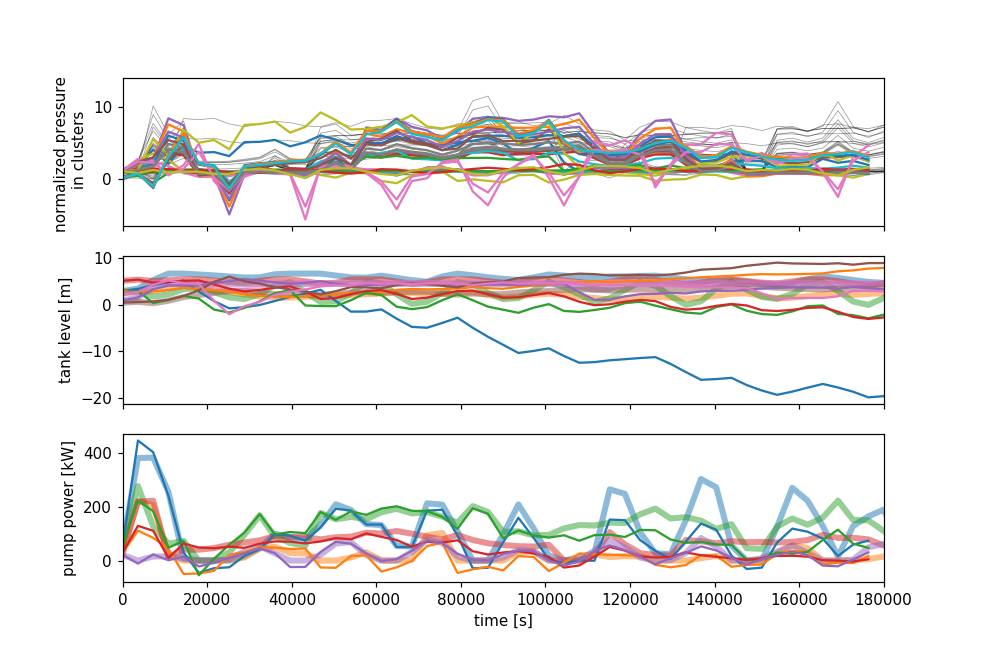

Text(0.5, 0, 'time [s]')

In [71]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,6))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')

# Linear Model

In [ ]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [ ]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [ ]:
for k in range(10):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = sys_aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

In [ ]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')